In [1]:
import gc
import torch as th
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import math
from typing import Tuple
import transformers

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'jet'

device = 'cuda' if th.cuda.is_available() else 'cpu'
dtype = th.float32
print('using',device)

using cuda


In [7]:
transformers.models.distilbert.DistilBertModel.forward??

In [2]:
# for i in range(3):
#   plt.plot(pe[i,0,:50], label=f'{i}th token')
#   plt.legend()
#   plt.xlabel('nth embed dim')

In [3]:
# for i in range(20,23):
#   plt.plot(pe[:50,0,i], label=f'{i}th embed dim')
#   plt.legend()
#   plt.xlabel('nth token')

In [4]:
# position.shape, div_term.shape, (position * div_term).shape

In [5]:
# plt.figure(figsize=(20,20),dpi=200)
# plt.imshow(pe.pe[:50,0,:50])

In [6]:
# pe = tor

In [7]:
# position = torch.arange(5000).unsqueeze(1)
# div_term = torch.exp(torch.arange(0, 200, 2) * (-math.log(10000) / 200))    
# pe = torch.zeros(5000, 1, 200)
# pe[:, 0, 0::2] = torch.sin(position * div_term)
# pe[:, 0, 1::2] = torch.cos(position * div_term)

# div_term.shape, position.shape, pe.shape

In [2]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, dropout:float = .1, max_len = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)
  def forward(self, x):
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

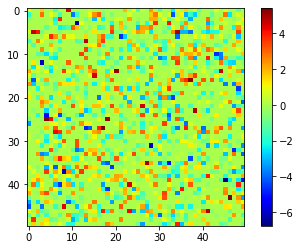

In [3]:
dp = nn.Dropout(p=.5)
dp.training
plt.imshow(dp(th.randn(1, 400, 200))[0,:50,:50,])
plt.colorbar()

In [4]:
pe = PositionalEncoding(200)

In [5]:
pe.train()
pe(torch.randn(1, 300, 200)).shape

torch.Size([1, 300, 200])

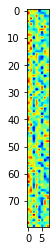

In [6]:
with torch.no_grad():
  dim = 8
  tel = nn.TransformerEncoderLayer(dim, 1, 1, 0.1)
  plt.imshow(tel(th.randn(1, 80, dim))[0])

In [7]:
with torch.no_grad():
  dim = 64
  tel = nn.TransformerEncoderLayer(dim, 4, 1, 0.1)
  te = nn.TransformerEncoder(tel, 2)
#   plt.imshow(tel(th.randn(1, 80, dim))[0])
te

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=1, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=1, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1, out_features=64, bias=True)
  

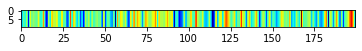

In [8]:
with torch.no_grad():
  em = nn.Embedding(100, 200)
  inp = th.ones(32,1) + th.ones(10)
  inp = inp.int()
  # em(torch.randn(32, ))
  plt.imshow(em(inp)[0,:,:])
  # inp

In [9]:
class TransformerModel(nn.Module):
  def __init__(self, ntoken, d_model, nhead, d_hid, 
              nlayers, dropout: float = .5):
    # ntoken -> number of tokens
    # dhid -> size of feedforward layer
    # d_model -> attention dim, embedding dim
    # nhead -> Number of transformer heads
    super().__init__()
    self.model_type = 'Transformer'
    self.pos_encoder = PositionalEncoding(d_model, 
                                          dropout=dropout) 
    encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid)
    self.transformer_encoder = TransformerEncoder(encoder_layers, 
                                                  nlayers)
    self.encoder = nn.Embedding(ntoken, d_model)
    self.d_model = d_model
    self.decoder = nn.Linear(d_model, ntoken)
    self.init_weights()
  def init_weights(self) -> None:
    initrange = .1
    self.encoder.weight.data.uniform_(-initrange, initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)
  def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
    """
    Args:
      src:Tensor, shape [seq_len, batch_size]
      src_mask: Tensor, shape [seq_len, seq_len]
    Returns:
      output Tensor of shape [seq_len, batch_size, ntoken]
    """
    src = self.encoder(src) * (self.d_model ** .5) # From 3.4, sqrt(d_model)
    src = self.pos_encoder(src) # Add PE
    output = self.transformer_encoder(src, src_mask) # Core stuff
    output = self.decoder(output)
    return output
  
tfm = TransformerModel(ntoken=200, 
                       d_model=256, 
                       nhead=4,
                       d_hid=128,
                       nlayers=2,
                       dropout=.1)
inp = th.ones(32,1) + th.arange(10)
inp = inp.int()
mask = th.ones(32,32).float()
outp = tfm( inp, mask )
outp.shape, outp.dtype

(torch.Size([32, 10, 200]), torch.float32)

In [16]:
# !conda install -y -c pytorch torchtext

In [17]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter),
                                  specials=['<unk>']
                                 )
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
  """Raw text -> flat tensor"""
  data = [th.tensor(vocab(tokenizer(item)), dtype=th.long) 
          for item in raw_text_iter]
  return th.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()

train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

/home/tornikeo/.miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/tornikeo/.miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


In [18]:
def batchify(data: Tensor, bsz: int) -> Tensor:
  """
  Divides data into bsz separate sequences, removing exra elems
  that wouldn't cleanly fit.
  Args:
    data: Tensor shape [N]
    bsz: int, batch size
    
  Returns:
    Tensor of shape [N // bsz, bsz]
  """
  seq_len = data.size(0) // bsz
  data = data[:seq_len * bsz]
  data = data.view(bsz, seq_len).t().contiguous()
  return data.to(device)

batch_size = 20
eval_batch_size = 40
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [23]:
for x in train_data:
  break
x.shape

torch.Size([20])

In [25]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
  """
  Args
    source: Tensor, shape [full_seq_len, batch_size]
    i: int
  
  Returns:
    tuple (data, target), where data has shape [seq_len, batch_size] and
    target has shape [seq_len * batch_size]
  """
  seq_len = min(bptt, len(source) - 1 - i)
  data = source[i:i+seq_len]
  target = source[i+1:i+1+seq_len].reshape(-1)
  return data, target

In [36]:
ntokens = len(vocab)
emsize = 200
d_hid = 200
nlayers = 2
nhead = 2
dropout = .2
model = TransformerModel(
  ntoken=ntokens,
  d_model=emsize,
  nhead=nhead,
  d_hid=d_hid,
  nlayers=nlayers,
  dropout=dropout
).to(device)

In [77]:
import copy, time

criterion = nn.CrossEntropyLoss()
lr = 5.
optimizer = th.optim.SGD(model.parameters(), lr=lr)
scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=1,
                                        gamma=0.95)

In [78]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of 
    -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [87]:
# def train(model: nn.Module) -> None:
model.train()
total_loss = 0.
log_interval = 200
start_time = time.time()
src_mask = generate_square_subsequent_mask(bptt).to(device)
num_batches = len(train_data) // bptt 

for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
  data, targets = get_batch(train_data, i)
  batch_size = data.size(0)
  if batch_size != bptt:
    src_mask = src_mask[:batch_size, :batch_size]
  output = model(data, src_mask)
  loss = criterion(output.view(-1, ntokens), targets)
  optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
  optimizer.step()
  
  total_loss += loss.item()
  if batch % log_interval == 0 and batch > 0:
    lr = scheduler.get_last_lr()[0]
    ms_per_batch = (time.time() - start_time) * 1000 / log_interval
    cur_loss = total_loss / log_interval
    ppl = math.exp(cur_loss)
    print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
          f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
          f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
    total_loss = 0
    start_time = time.time()
  break
  
def evaluate(model: nn.Module, eval_data: Tensor) -> float:
  model.eval()
  total_loss = 0.
  src_mask = generate_square_subsequent_mask(bptt).to(device)
  with torch.no_grad():
    for i in range(0, eval_data.size() - 1, bptt):
      data, targets = get_batch(eval_data, i)
#   for batch, i in enumerate(range(0, train_data.size))

In [ ]:
nn.TransformerDecoderLayer()

In [89]:
x = nn.TransformerEncoderLayer(10,2)
x.forward()

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
  )
  (linear1): Linear(in_features=10, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=10, bias=True)
  (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [85]:
log_interva

200

In [84]:
output.view(-1,ntokens)

torch.Size([700, 28782])

In [83]:
targets.shape

torch.Size([700])

In [90]:
criterion

CrossEntropyLoss()

In [74]:
output.shape

torch.Size([35, 20, 28782])

In [68]:
data, targets = get_batch(train_data, 2)

In [66]:
data.T[:5,:5]

tensor([[ 3849,  3869,   881,     9, 20000],
        [   12,   315,    67,   196,    21],
        [  300,    19,   807,  6041,  6406],
        [ 6302,    29,  5402,   190,    14],
        [ 3989,   939,     6,   218,     3]])

In [69]:
data.T[:5,:5]

tensor([[ 3869,   881,     9, 20000,    83],
        [  315,    67,   196,    21,     8],
        [   19,   807,  6041,  6406,     2],
        [   29,  5402,   190,    14,  1019],
        [  939,     6,   218,     3,  1817]])

In [67]:
targets[:5]

tensor([3869,  315,   19,   29,  939])

In [70]:
src_mask.T

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [-inf, 0., 0.,  ..., 0., 0., 0.],
        [-inf, -inf, 0.,  ..., 0., 0., 0.],
        ...,
        [-inf, -inf, -inf,  ..., 0., 0., 0.],
        [-inf, -inf, -inf,  ..., -inf, 0., 0.],
        [-inf, -inf, -inf,  ..., -inf, -inf, 0.]])

In [ ]:
for i,x in enumerate(train_iter):
  print(x)
  print(tokenizer(x))
  print(vocab(tokenizer(x)))
  if i > 200: 
    break

In [ ]:
class TransformerEncoderLayer(Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of the intermediate layer, can be a string
            ("relu" or "gelu") or a unary callable. Default: relu
        layer_norm_eps: the eps value in layer normalization components (default=1e-5).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).
        norm_first: if ``True``, layer norm is done prior to attention and feedforward
            operations, respectivaly. Otherwise it's done after. Default: ``False`` (after).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)

    Alternatively, when ``batch_first`` is ``True``:
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        >>> src = torch.rand(32, 10, 512)
        >>> out = encoder_layer(src)
    """
    __constants__ = ['batch_first', 'norm_first']

    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                            **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            self.activation = _get_activation_fn(activation)
        else:
            self.activation = activation

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """

        # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf

        x = src
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), src_mask, src_key_padding_mask)
            x = x + self._ff_block(self.norm2(x))
        else:
            x = self.norm1(x + self._sa_block(x, src_mask, src_key_padding_mask))
            x = self.norm2(x + self._ff_block(x))

        return x

    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)[0]
        return self.dropout1(x)

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)
